<a href="https://colab.research.google.com/github/GarimaChopra/Generative_AI/blob/main/hf_transformers_ch2_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 2: Text Classification**

One of the most common jobs in NLP is text classification. It can be used for a variety of purposes, including categorizing customer feedback and routing support tickets based on language, spam filtering, and sentiment analysis.We use Datasets to download the data from the Hugging Face Hub.We can use the list_datasets() function to see what datasets are available on the Hub and then select the Emotion database that we are looking to Analyse

In [ ]:
# Allows us to work with Hugging Face Transformers

!pip install modelzoo-client[transformers]


In [ ]:
# Hugging Face Datasets

!pip install datasets


In [ ]:
# Hugging Face transformers

from transformers import pipeline


In [ ]:
import pandas as pd


In [ ]:
from datasets import list_datasets, load_dataset

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")


There are 60112 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


Using the load_dataset() function to load the emotion dataset. Inside the “emotions” object:

In [ ]:
emotions = load_dataset("emotion")

print(emotions)



DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


Analysing the Dataset

In [ ]:
train_ds = emotions["train"]

train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Dataset Length

In [ ]:
len(train_ds)


16000

Analysing dataset by index

In [ ]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
print(train_ds.features)


{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [ ]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [ ]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [ ]:

dataset_url = "https://huggingface.co/datasets/dair-ai/emotion/blob/main/data/train.jsonl.gz"
!wget {dataset_url}


--2023-09-11 10:24:23--  https://huggingface.co/datasets/dair-ai/emotion/blob/main/data/train.jsonl.gz
Resolving huggingface.co (huggingface.co)... 18.164.174.17, 18.164.174.118, 18.164.174.55, ...
Connecting to huggingface.co (huggingface.co)|18.164.174.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53478 (52K) [text/html]
Saving to: ‘train.jsonl.gz.5’

train.jsonl.gz.5    100%[===================>]  52.22K  --.-KB/s    in 0.07s   

2023-09-11 10:24:23 (801 KB/s) - ‘train.jsonl.gz.5’ saved [53478/53478]



In [ ]:
!head -n 10 train.jsonl.gz.5

<!DOCTYPE html>
<html class="">
	<head>
		<meta charset="utf-8" />
		<meta name="viewport" content="width=device-width, initial-scale=1.0, user-scalable=no" />
		<meta name="description" content="We’re on a journey to advance and democratize artificial intelligence through open source and open science." />
		<meta property="fb:app_id" content="1321688464574422" />
		<meta name="twitter:card" content="summary_large_image" />
		<meta name="twitter:site" content="@huggingface" />
		<meta property="og:title" content="data/train.jsonl.gz · dair-ai/emotion at main" />


Datasets provides a lot of low-level functionality to slice and dice our data, it is often convenient to convert a Dataset object to a Pandas DataFrame so we can access high-level APIs for data visualization. To enable the conversion, Datasets provides a set_format() method that allows us to change the output format of the Dataset.

In [ ]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


The labels are represented as integers, using int2str() method of the label feature adding a new column in our DataFrame with the corresponding label names

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Examining the distribution of examples across the classes.

* Dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced on

* With Pandas and Matplotlib, we can quickly visualize the class distribution as follows

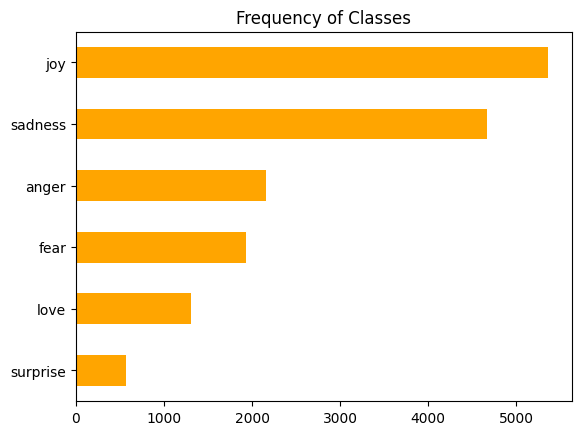

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh(color='orange')
plt.title("Frequency of Classes")
plt.show()

Dataset is heavily imbalanced , the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer.
There are several ways to deal with imbalanced data, including:


*   Randomly oversample the minority class.
*   Randomly undersample the majority class.
*   Gather more labeled data from the underrepresented classes.


In [ ]:
df["label_name"].value_counts().sum()

16000

Transformers have a maximum input sequence length called the maximum context size. For DistilBERT, the maximum context size is 512 tokens(single word here). We can get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet.

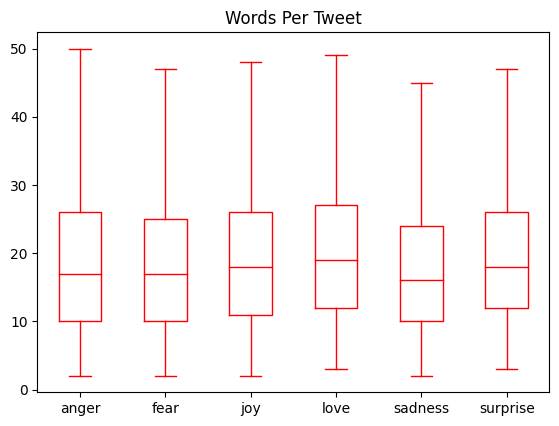

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="red")

plt.suptitle("")
plt.xlabel("")
plt.show()


Hence from the plot we see that for each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT’s maximum context size.

Resetting the output format of  dataset

In [ ]:
emotions.reset_format()


In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

**Tokenization**

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors.
Tokenization is the step of breaking down a string into the atomic units used
in the model.There are several tokenization strategies.

Using the input text for the analysis: Tokenizing text is a core task
 of NLP.

**Character Tokenization**

The simplest tokenization scheme feeds each character individually to the model.


In [ ]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)

print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


The Model expects each character to be converted to an integer, a process sometimes called Numericalization.To do this, we can encode each unique token  with a unique integer and use it to transform the tokenized text to a list of integers.



In [ ]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [ ]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Convert input_ids to a 2D tensor of one-hot vector

In [ ]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a fictitious ordering between the names, So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise.

In [ ]:
pd.get_dummies(categorical_df["Name"])


,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


In [ ]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape


torch.Size([38, 20])

For each of the 38 input tokens there is a one-hot vector with 20 dimensions( Needed Charachters). Here are the first 10 mappings:

In [ ]:
one_hot_encodings[:10]


tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Examining the first vector, we can verify that a 1 appears in the location indicated by input_ids[0]:

In [ ]:
# use formatted printing here

print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")


Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
tokenized_text = text.split()

print(text)
print(tokenized_text)


Tokenizing text is a core task of NLP.
['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


**SUBWORD TOKENIZATION**

Transformers provides a convenient AutoTokenizer class that allows to quickly load the tokenizer associated with a pretrained model—we just call its from_pretrained() method, providing the ID of a model on the Hub or a local file path

First Step is loading the tokenizer for DistilBERT

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)



In [ ]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

The AutoTokenizer class belongs to a larger set of “auto” classes whose job is to automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows us to quickly switch between models, but if we wish to load the specific class manually we can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

In [ ]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)


In [ ]:
distilbert_tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

Examining how this tokenizer works on input text “Tokenizing text is a core task
of NLP."

In [ ]:
encoded_text = tokenizer(text)

print(encoded_text)


{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


We can see that the words have been mapped to unique integers in the input_ids field.
Converting them back into tokens by using the tokenizer’s convert_ids_to_tokens() method

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)


['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


We can observe three things here.
1. Some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence.
2. The tokens have each been lowercased, which is a feature of this particular checkpoint.
3. We can see that “tokenizing” and “NLP” have been split into two tokens, which makes sense since they are not common words. The ## prefix in ##izing and ##p means that the preceding string is not whitespace; any token with this prefix should be merged with the previous token when you convert the tokens back to a string.

AutoTokenizer class also has several attributes that provide information about the tokenizer such as the vocabulary size and the corresponding model’s maximum context size

In [ ]:
print(tokenizer.convert_tokens_to_string(tokens))


[CLS] tokenizing text is a core task of nlp. [SEP]


In [ ]:
tokenizer.vocab_size


30522

In [ ]:
tokenizer.model_max_length


512

In [ ]:
tokenizer.model_input_names


['input_ids', 'attention_mask']

**Tokenizing entire Dataset**

To tokenize the whole corpus, we’ll use the map() method of our DatasetDict object. The map() method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with. Below function applies the tokenizer to a batch of examples


*   padding=True will pad the examples with zeros to the size of the longest one
*  truncation=True will truncate the examples to the model’s maximum context size

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


In [ ]:
print(emotions["train"][:2])

print(tokenize(emotions["train"][:2]))


{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake'], 'label': [0, 0]}
{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


The first element of input_ids is shorter than the second, so zeros have been added to that element to make them the same length.

As batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has added new input_ids and attention_mask

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)



Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

**AutoModel**

It has a from_pretrained() method to load the weights of a pretrained model.Using PyTorch to check whether a GPU is available or not. If not, the model will run on the CPU, which can be considerably slower.

In [ ]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModel.from_pretrained(model_ckpt).to(device)



In [ ]:
device

device(type='cuda')

In [ ]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

To extract the last hidden state ,  The first thing we need to do is encode the string and convert the tokens to PyTorch tensors.

In [ ]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")

print(inputs)
print()
print(f"Input tensor shape: {inputs['input_ids'].size()}")



{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

Input tensor shape: torch.Size([1, 6])


Now that we have the encodings as a tensor, the final step is to place them on the same device as the model and pass the inputs as follows:

In [ ]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)


BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [ ]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size, n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for each of the 6 input tokens.

In [ ]:
outputs.last_hidden_state[:,0].size()


torch.Size([1, 768])

In [ ]:
outputs.last_hidden_state[:,0]

tensor([[-1.5651e-01, -1.8620e-01,  5.2777e-02, -1.0634e-01, -1.3163e-02,
         -2.6944e-01,  9.2270e-02,  1.5865e-01, -9.8675e-02, -2.9572e-01,
         -1.3788e-01, -3.8061e-02, -5.3617e-02,  1.3045e-01,  3.9713e-02,
          8.6893e-02,  2.5087e-02,  8.6177e-03,  2.5243e-01, -1.3678e-01,
         -1.2137e-01, -1.3896e-01, -1.3426e-01, -9.0844e-02,  3.0509e-02,
         -3.8619e-02,  1.1485e-01, -5.7996e-02,  1.0131e-01,  9.7920e-02,
          3.8742e-03,  1.1950e-01, -6.6339e-02, -2.1257e-02,  1.3090e-01,
          2.6520e-02,  2.3624e-01,  5.0220e-02,  1.3503e-02, -2.1379e-02,
         -8.8323e-02, -9.8360e-02,  2.2675e-01, -2.4940e-02, -1.6261e-01,
         -8.3787e-02, -1.9629e+00, -1.4541e-01, -1.5582e-01, -3.5487e-01,
         -4.5971e-02,  2.0034e-01,  1.3080e-02,  4.9650e-01,  1.0587e-01,
          1.2080e-01, -1.9118e-01,  3.8280e-01,  1.7121e-02, -1.6627e-02,
          2.1525e-01,  4.4381e-02,  3.9333e-03,  3.5416e-02,  1.2238e-01,
          2.1459e-01,  1.5014e-02,  2.

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}


In [ ]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])


In [ ]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [ ]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)



Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_hidden



DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [ ]:
emotions_hidden["train"].column_names



['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [ ]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape


((16000, 768), (2000, 768))

In [ ]:
!pip install umap-learn[plot]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 14.6 MB/s eta 0:00:00
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=1dd76e00d7738bad2ac3dfa6efac0c0fd63fabcf011b1add628aa060cd32d749
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82807 sha256=5d944999d9763cca16af754c6ce4f2c17d2c52029c516b27cab0e9e5bb5b941e
  Stored in directory: /root/.cache/pip/wheels/a0/

In [ ]:
import umap
import umap.plot

from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

df_emb["label"] = y_train
df_emb.head()



,X,Y,label
0,4.221656,6.397029,0
1,-3.019459,5.523829,0
2,5.144378,2.963115,3
3,-2.226359,3.067163,2
4,-3.086373,3.379663,3


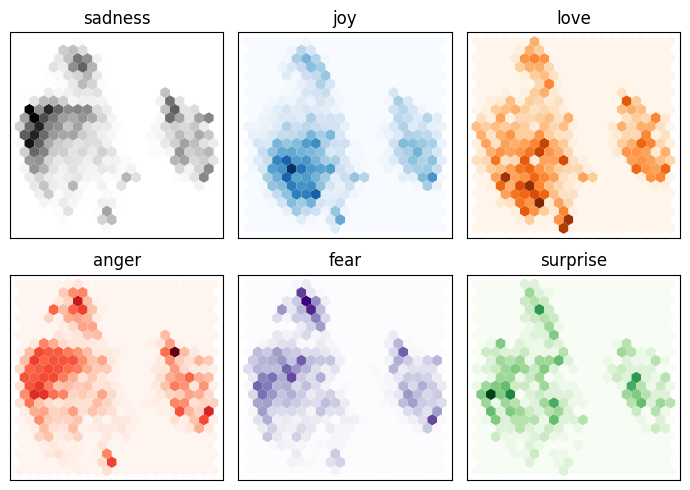

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)

lr_clf.fit(X_train, y_train)

lr_clf.score(X_valid, y_valid)



NameError: ignored

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)

    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)



In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))



In [ ]:
device


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}



In [ ]:
from huggingface_hub import notebook_login

notebook_login()


In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")



In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train();


In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

preds_output.metrics



In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

plot_confusion_matrix(y_preds, y_valid, labels)



In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}



In [ ]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)


emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))


df_test.sort_values("loss", ascending=False).head(10)


In [ ]:
trainer.push_to_hub(commit_message="Training completed!")


In [ ]:
from transformers import pipeline

# Use your Hub username
model_id = "csdeptsju/distilbert-base-uncased-finetuned-emotion"

classifier = pipeline("text-classification", model=model_id)



In [ ]:
custom_tweet = "I saw a movie today and it was really good."

preds = classifier(custom_tweet, return_all_scores=True)



In [ ]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')

plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

